# WIRC+POL Data Reduction Tutorial #
Welcome to the WIRC+POL data reduction pipeline (DRP) tutorial. The notebook will give you a basic run 
through of how to reduce WIRC+POL data and give you some details about the setup of the pipeline. 

### Pipeline Description ###
The pipeline has been designed so that once read-in, each data file will be held in an object called a *wirc_data* object. Each *wircpol_data* object will contain, the raw (or calibrated) 2D data itself, relevant information about the data and a number of functions that will calibrate and process the data. It will also contain a list of *wircpol_source* objects, where each *wircpol_source* will correspond to a source in the field. The source object will contain thumbnails of the spectral traces, as well as the extracted spectrum and polarized spectrum for each source.

Note: The current implementation has been designed with WIRC+POL data in mind, but we hope to extent this to WIRC+Spec data soon. 

### Assumptions ###
We assume that you have set an environment variable called "WIRC_DRP" that points to the base directory of the DRP and that it is in your python path. Beyond the standard python packages we also assume you have astropy installed. 

### The Tutorial ### 
This tutorial will give an example of reducing a raw WIRC+POL data image from start to finish, and will give you an idea of the implementation of the pipeline along the way. We'll note that many of the later data reduction steps (e.g. spectral extraction) are works in progress, and so the final data products should not yet be used for science. The purpose of this tutorial is more to demonstrate the features of the pipeline rather than to teach you how to fully calibrate your data. 

## Step 0 - Make your calibration files ##
The very first step will be to create your own master darks and master flats. For the sake of this tutorial we well assume that you have done this already, but we provide somed example code commented-out below. Already-made master darks and flats have been provided in the tutorial directory. 

In [7]:
#Import the important things
%matplotlib inline
import wirc_drp.wirc_object as wo
from wirc_drp.utils import calibration
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.ascii as asci
import os

##### Create a master dark #####
First you will need a list of files that will go into the master dark. It can be created like this: 

__bash> ls dark*.fits > dark_list.dat__

Then you read it in and create your mater dark by taking the median of all the files in the list. A hotpixel map will also be generated by default.  

In [8]:
### Get the file list 
# dark_list_fn = "dark_list.dat" #The file name for your list of dark files
# dark_list = (asci.read(dark_list_fname, format = 'fast_no_header'))['col1'] #Read in the list

### Create the master dark and a bad pixel map.
### This function creates a new fits file based on the last filename in your dark_list and appends "_master_dark.fits"
### The hot pixel map will be the same, except with a "_bp_map.fits" suffix. 
# dark_name, bp_name = calibration.masterDark(dark_list) # The output of this function is a the filename 
                                                         # of the master dark and bad pixel maps


##### Create a master flat #####
First you will need a list of files that will go into the master flat. It can be created like this: 

__bash> ls flat*.fits > flat_list.dat__

Then you read it in and create your mater flat by subtracting the master dark from each image, taking the median of all the files in the list and then normalize by either the median (default) or the mode, set by the *normalize* keyword. A bad pixel map will also be generated by default, which you can supplement with the hot pixel map output by creating the master dark. 

In [9]:
### Get the file list 
# flat_list_fname = "flat_list.dat" #The file name for your list of flat files
# flat_list = (a.read(flat_list_fname, format = 'fast_no_header'))['col1']

### Create the master dark and a bad pixel map. You will need the filename 
### This function creates a new fits file based on the last filename in your flat list and appends "_master_flat.fits"

# flat_name, bp_name = calibration.masterFlat(flat_list, dark_name1, hotp_map_fname = None) 

## Step 1 - Read in and calibrate your data ##
Assuming that you now have a master dark and master flat file, we can now read in a wirc_data file and perform the calibration. 

In [10]:
#First we'll set up all the directories and filenames: 
wircpol_dir = os.environ['WIRC_DRP'] # Your WIRCPOL_DRP directory (with a "/" at the end!)
tutorial_dir = wircpol_dir + "Tutorial/"

raw_fn =tutorial_dir+"wirc1586.fits"
flat_fn = tutorial_dir+"wirc2012_master_flat.fits"
dark_fn = tutorial_dir+"wirc0141_master_dark.fits"
bp_fn = tutorial_dir+"wirc2012_bp_map.fits"

In [11]:
#Now we'll create the wirc_data object, passing in the filenames for the master dark, flat and bad pixel maps
raw_data = wo.wirc_data(raw_filename=raw_fn, flat_fn = flat_fn, dark_fn = dark_fn, bp_fn = bp_fn)

Creating a new wirc_data object from file /Users/kaew/work/wircpol/wirc_drp/Tutorial/wirc1586.fits
Found a J-band filter in the header of file /Users/kaew/work/wircpol/wirc_drp/Tutorial/wirc1586.fits


The wirc_data object holds the 2D data image in the property full_image. We can take a look at it now: 

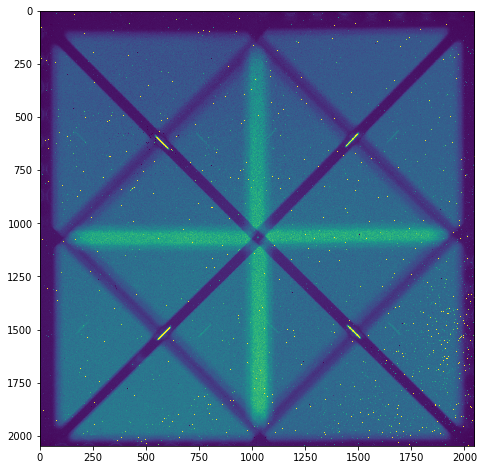

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(raw_data.full_image, vmin=0, vmax=5000)

We can see (even in this zoomed out image) that there are a bunch of bad pixels. Let's run the calibration step. It will subtract the dark, divide by the flat, and interpolate over the bad pixels. 

In [13]:
raw_data.calibrate(mask_bad_pixels=False)

Subtracting /Users/kaew/work/wircpol/wirc_drp/Tutorial/wirc0141_master_dark.fits from each file
Dividing each file by /Users/kaew/work/wircpol/wirc_drp/Tutorial/wirc2012_master_flat.fits
Using bad pixel map /Users/kaew/work/wircpol/wirc_drp/Tutorial/wirc2012_bp_map.fits


/Users/kaew/work/wircpol/wirc_drp/wirc_object.py:120: RuntimeWarning: invalid value encountered in true_divide
  redux = ((self.full_image - factor*master_dark)/master_flat)
/Users/kaew/work/wircpol/wirc_drp/utils/calibration.py:317: RuntimeWarning: invalid value encountered in less_equal
  bad_pixel_map = np.logical_or(bad_pixel_map, redux_science <= 0)


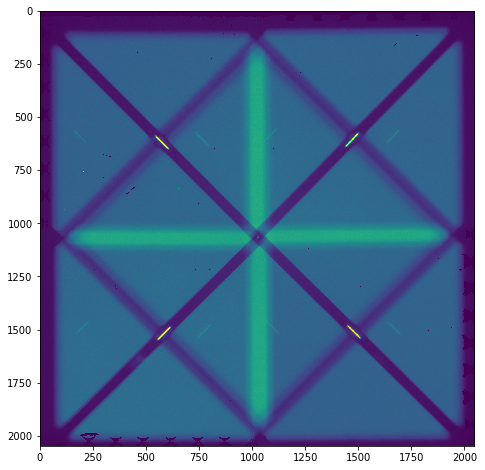

In [14]:
plt.figure(figsize=(8,8))
plt.imshow(raw_data.full_image, vmin=0, vmax=5000)

There are a few remaining artifacts in the image, but overall, not bad! 

We're now done with calibration and so we want to save our newly calibrated file. Up until now these steps can apply to both spec mode and pol mode data. However, the rest of the tutorial will just demonstrate how to reduce POL data. 

In [15]:
raw_data.save_wirc_object("calibrated.fits")

Saving a wirc_object to calibrated.fits


## Step 2 - Extract the thumbnails of the spectral traces ##
In this step we will give the wirc_object the location of the central mask hole, and it will create a source object. Each source object will contain cutout thumbnails of each spectral trace, and eventually spectra and polarized spectra. 

In [16]:
#First we'll create a new data object, mostly just to demonstrate how to read in an existing wirc_data object. 
calibrated_data = wo.wirc_data(wirc_object_filename="calibrated.fits")

Loading a wirc_data object from file calibrated.fits


In [17]:
#We'll now attempt to find sources in the image. 
calibrated_data.find_sources()

No direct image filename given. For now we can only find sources automatically in a direct image, so we'll assume that there's a source in the middle slit. If you wish you can add other sources as follows: 

 > wirc_data.source_list.append(wircpol_source([y,x],slit_pos,wirc_data.n_sources+1)             #where slit_pos is '0','1','2' or slitless. 
 > wirc_data.n_sources += 1


Source objects are kept in a python list called *source_list* and the number of sources are kept in a variable called *n_sources*.

In [18]:
#For the source let's now get the cutouts of the spectra. 
calibrated_data.source_list[0].get_cutouts(calibrated_data.full_image, calibrated_data.filter_name, True)


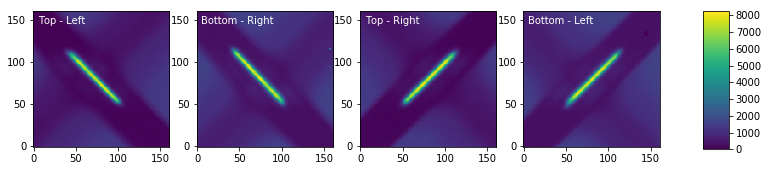

In [20]:
#Now let's take a look at them!
calibrated_data.source_list[0].plot_cutouts(origin = 'lower')

In [21]:
#We'll now manually add another source in the field with the instructions above: 
calibrated_data.source_list.append(wo.wircpol_source([1035,640],'slitless',calibrated_data.n_sources+1))
calibrated_data.n_sources += 1
calibrated_data.source_list[1].get_cutouts(calibrated_data.full_image, calibrated_data.filter_name, True)
#The final argument being passed is a boolean that determines whether or not we compensate for hitting 
#the vertical bar of doom. Play with it to see the different results. How to properly compensate for this
#is a work in progress. 

Source 1's traces will hit the vertical bar of doom, compensating by subtracting the median of the edges of each row


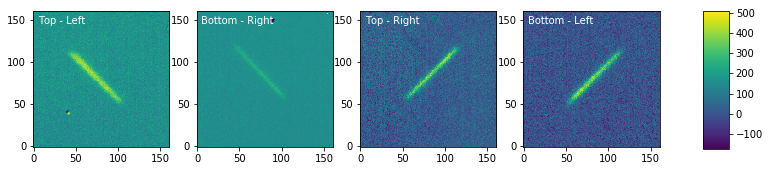

In [23]:
calibrated_data.source_list[1].plot_cutouts(origin = 'lower')

## Step 3 - Extract the spectra from each thumbnail ##
In this step we will extract the specta from one of the source objects we found in Step 2.

In [24]:
#Here you can enable "plot" to see where the traces were "found"
calibrated_data.source_list[0].extract_spectra(plot=False)

Performing Spectral Extraction for source 1
Extracting spectra from trace 0 of 4
Extracting spectra from trace 1 of 4
Extracting spectra from trace 2 of 4
Extracting spectra from trace 3 of 4


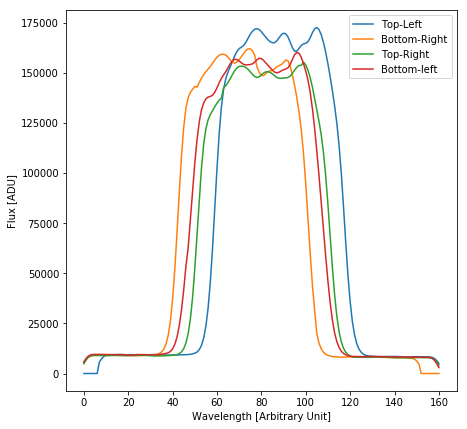

In [25]:
#And we'll plot the data!
calibrated_data.source_list[0].plot_trace_spectra()

Now we'll do a rough wavelength calibration. Currently it uses the edge of the filters to shift and scale the spectra. This will eventually need to be refined as we're not super happy with it. 

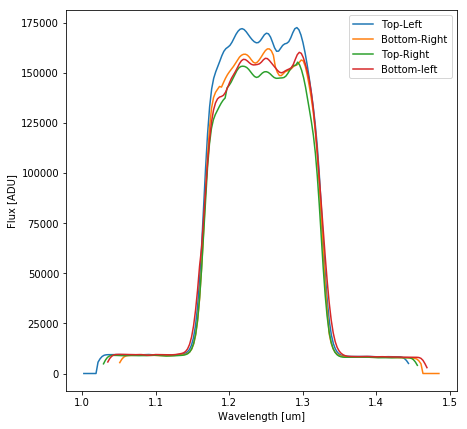

In [26]:
## Now we'll do a rough wavelength calibration and plot the data again
calibrated_data.source_list[0].rough_lambda_calibration(method=2) 
#Note method=1 is broken. 

#And we'll plot the data again. 
calibrated_data.source_list[0].plot_trace_spectra()

## Step 4 - Calculate the polarized spectra ##
We now combine the 4 spectra to calculate Stokes Q and U

In [ ]:
calibrated_data.source_list[0].compute_polarization(cutmin=20, cutmax=150)

In [ ]:
calibrated_data.source_list[0].plot_Q_and_U(plot_error = True)